In [29]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import InceptionV3

In [30]:
os.chdir('/')
!unzip /chest_xray.zip -d /content/chest_xray/

Streaming output truncated to the last 5000 lines.
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0655-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0656-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0656-0001-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0656-0001-0002.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0657-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0658-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0659-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0660-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0660-0001-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0660-0001-0002.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0661-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0662-0001.jpeg  
  inf

Importing Data

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
train = get_training_data('/content/chest_xray/chest_xray/train')
test = get_training_data('/content/chest_xray/chest_xray/test')
val = get_training_data('/content/chest_xray/chest_xray/val')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


EDA

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


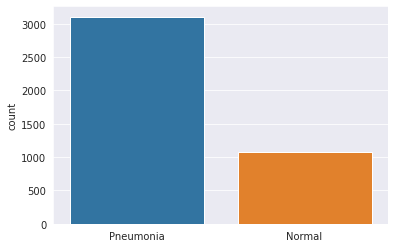

In [ ]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)  

Text(0.5, 1.0, 'NORMAL')

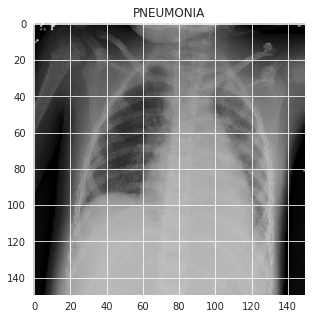

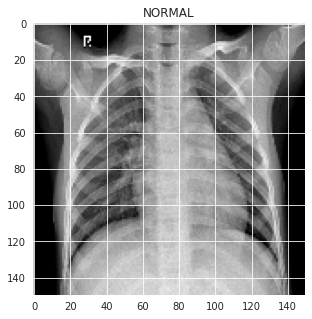

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

Data Preparation

In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 3)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)

print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

Train: X=(4185, 150, 150, 3), y=(4185,)
Test: X=(624, 150, 150, 3), y=(624,)


In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range = 30, 
        zoom_range = 0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True,
        vertical_flip=False)


datagen.fit(x_train)

CNN Model

In [ ]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 25 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

predictions = model.predict_classes(x_test)

predictions = predictions.reshape(1,-1)[0]
predictions

print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.93      0.93      0.93       390
   Normal (Class 1)       0.88      0.88      0.88       234

           accuracy                           0.91       624
          macro avg       0.90      0.91      0.90       624
       weighted avg       0.91      0.91      0.91       624



In [ ]:
predictions_values_CNN = model.predict(x_test)
predictions_values_CNN

array([[1.05707400e-01],
       [1.94900617e-01],
       [2.08098939e-07],
       [1.34156371e-05],
       [1.33238837e-01],
       [6.08753227e-02],
       [2.18675226e-01],
       [5.70210441e-11],
       [9.07354429e-02],
       [2.54600048e-01],
       [2.60264780e-02],
       [9.96040064e-04],
       [1.58093815e-06],
       [5.13270199e-02],
       [9.84224916e-01],
       [6.14082888e-02],
       [2.79360628e-13],
       [1.66976571e-01],
       [1.25668194e-05],
       [5.92321747e-10],
       [1.38014257e-02],
       [1.77513499e-07],
       [6.46024823e-01],
       [5.07236412e-03],
       [1.73138108e-08],
       [3.02340681e-15],
       [5.35000153e-02],
       [1.47677410e-05],
       [4.24186975e-01],
       [4.49138917e-02],
       [1.63035875e-15],
       [2.55287625e-04],
       [9.87105966e-01],
       [4.11531437e-06],
       [1.33930534e-01],
       [1.52233496e-01],
       [1.68529488e-02],
       [1.15642846e-01],
       [4.22735162e-08],
       [7.87270144e-02],


In [ ]:
predictions = model.predict_classes(x_test)

predictions = predictions.reshape(1,-1)[0]
predictions

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [ ]:
cm = confusion_matrix(y_test,predictions)
cm

array([[361,  29],
       [ 27, 207]])

In [ ]:
print("Accuracy of CNN Model:"+str((361+207)/(361+207+27+29)))

Accuracy of CNN Model:0.9102564102564102


ResNet50 Model

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 224
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

train = get_training_data('/content/chest_xray/chest_xray/train')
test = get_training_data('/content/chest_xray/chest_xray/test')
val = get_training_data('/content/chest_xray/chest_xray/val')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)
    
    
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255


x_train = x_train.reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 3)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range = 30, 
        zoom_range = 0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True,
        vertical_flip=False)


datagen.fit(x_train)

In [ ]:
conv_base = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3))
conv_base.summary()

model2 = Sequential()
model2.add(conv_base)
model2.add(Flatten())
model2.add(Dropout(0.3))
model2.add(Dense(128, activation = 'relu'))
model2.add(Dense(1, activation = 'sigmoid'))
model2.summary()

model2.compile(
    loss = 'binary_crossentropy',
    optimizer = SGD(
    learning_rate=0.001, momentum=0.9, name="SGD"),
    metrics = ['acc'])

history2 = model2.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 25 ,
                      validation_data = datagen.flow(x_val, y_val))

94773248/94765736 [==============================] - 2s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

In [ ]:
predictions_ResNet = model2.predict_classes(x_test)

predictions_ResNet = predictions_ResNet.reshape(1,-1)[0]

cm = confusion_matrix(y_test,predictions_ResNet)
cm

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[385,   5],
       [ 35, 199]])

In [3]:
predictions_values_ResNet = model2.predict(x_test)
predictions_values_ResNet

NameError: ignored

In [89]:
np.array(predictions_values_ResNet)
ResNetPred = []
for val in predictions_values_ResNet:
  if val > [0.5]:
    ResNetPred.append(1)
  else:
    ResNetPred.append(0)

In [90]:
print(classification_report(y_test, ResNetPred, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.92      0.99      0.95       390
   Normal (Class 1)       0.98      0.85      0.91       234

           accuracy                           0.94       624
          macro avg       0.95      0.92      0.93       624
       weighted avg       0.94      0.94      0.93       624



In [ ]:
print("Accuracy of ResNet50 Model:"+str((385+199)/(385+199+35+5)))

Accuracy of ResNet50 Model:0.9358974358974359


DenseNet121

In [ ]:
conv_base = DenseNet121(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3))
conv_base.summary()

model3 = Sequential()
model3.add(conv_base)
model3.add(Flatten())
model3.add(Dropout(0.3))
model3.add(Dense(128, activation = 'relu'))
model3.add(Dense(1, activation = 'sigmoid'))
model3.summary()

model3.compile(
    loss = 'binary_crossentropy',
    optimizer = SGD(
    learning_rate=0.001, momentum=0.9, name="SGD"),
    metrics = ['acc'])

history3 = model3.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 10 ,
                      validation_data = datagen.flow(x_val, y_val))

predictions = model3.predict_classes(x_test)

predictions = predictions.reshape(1,-1)[0]

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
predictions_values_DenseNet = model3.predict(x_test)
predictions_values_DenseNet

array([[1.59396101e-02],
       [5.93319209e-03],
       [3.31253614e-06],
       [1.02593843e-03],
       [1.18278556e-04],
       [7.42659066e-03],
       [6.34718919e-04],
       [4.02331671e-06],
       [5.07198158e-04],
       [5.99746476e-04],
       [7.42033124e-04],
       [6.61847980e-06],
       [2.63136963e-06],
       [3.01317405e-03],
       [4.31512922e-01],
       [4.48703562e-04],
       [3.28357032e-07],
       [1.50028907e-03],
       [8.41210858e-05],
       [1.26401737e-05],
       [1.11983310e-04],
       [2.15453751e-04],
       [6.95663039e-03],
       [1.31659490e-05],
       [1.52675773e-06],
       [1.60452396e-06],
       [9.88155790e-03],
       [1.10825917e-04],
       [7.86962092e-01],
       [2.62821268e-04],
       [7.70351818e-08],
       [9.19978411e-05],
       [2.70997286e-02],
       [4.44207399e-06],
       [8.72182474e-03],
       [9.88434348e-03],
       [2.63100071e-03],
       [1.15675539e-04],
       [7.89076694e-06],
       [4.80290386e-04],


In [ ]:
predictions_DenseNet = model3.predict_classes(x_test)

cm = confusion_matrix(y_test,predictions_DenseNet)
cm

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[384,   6],
       [ 23, 211]])

In [ ]:
print(classification_report(y_test, predictions_DenseNet, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.94      0.98      0.96       390
   Normal (Class 1)       0.97      0.90      0.94       234

           accuracy                           0.95       624
          macro avg       0.96      0.94      0.95       624
       weighted avg       0.95      0.95      0.95       624



In [ ]:
print("Accuracy of DenseNet121 Model:"+str((384+211)/(384+211+23+6)))

Accuracy of DenseNet121 Model:0.9535256410256411


InceptionV3

In [31]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 229
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

train = get_training_data('/content/chest_xray/chest_xray/train')
test = get_training_data('/content/chest_xray/chest_xray/test')
val = get_training_data('/content/chest_xray/chest_xray/val')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


In [32]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)
    
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

x_train = x_train.reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 3)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)

In [ ]:
conv_base = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(229, 229, 3))
conv_base.summary()

model4 = Sequential()
model4.add(conv_base)
model4.add(Flatten())
model4.add(Dropout(0.3))
model4.add(Dense(128, activation = 'relu'))
model4.add(Dense(1, activation = 'sigmoid'))
model4.summary()

model4.compile(
    loss = 'binary_crossentropy',
    optimizer = SGD(
    learning_rate=0.001, momentum=0.9, name="SGD"),
    metrics = ['acc'])

history3 = model4.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 10 ,
                      validation_data = datagen.flow(x_val, y_val))

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 229, 229, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 114, 114, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 114, 114, 32) 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 114, 114, 32) 0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

In [ ]:
predictions_values_Inception = model4.predict(x_test)
predictions_values_Inception

array([[1.12682031e-02],
       [8.91416334e-03],
       [8.39206280e-07],
       [2.36909094e-04],
       [3.51184717e-05],
       [5.73549652e-04],
       [1.02154550e-03],
       [1.80222946e-06],
       [1.62057318e-02],
       [1.37076201e-03],
       [8.00712005e-05],
       [5.48314517e-07],
       [5.82358382e-07],
       [3.58827165e-05],
       [9.74414647e-02],
       [7.38078015e-05],
       [1.98686010e-08],
       [2.76022729e-06],
       [5.55222186e-06],
       [1.09715120e-05],
       [1.08679815e-03],
       [3.61566663e-07],
       [2.53905717e-04],
       [2.71063482e-06],
       [7.30009606e-06],
       [1.14554190e-07],
       [2.26152618e-03],
       [6.29633587e-06],
       [1.89835113e-02],
       [6.76940312e-04],
       [1.77040249e-06],
       [6.51871087e-05],
       [2.12328834e-03],
       [4.02238811e-06],
       [1.20226564e-02],
       [5.41136425e-04],
       [1.03195152e-05],
       [3.21654843e-05],
       [2.66370279e-07],
       [1.92238876e-04],


In [ ]:
predictions_Inception = model4.predict_classes(x_test)

cm = confusion_matrix(y_test,predictions_Inception)
cm

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[388,   2],
       [ 74, 160]])

In [ ]:
print(classification_report(y_test, predictions_Inception, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.84      0.99      0.91       390
   Normal (Class 1)       0.99      0.68      0.81       234

           accuracy                           0.88       624
          macro avg       0.91      0.84      0.86       624
       weighted avg       0.90      0.88      0.87       624



Weighted classifier

In [76]:
WCEqual = np.array(predictions_values_CNN)*0.25 + np.array(predictions_values_ResNet)*0.25 + np.array(predictions_values_DenseNet)*0.25 + np.array(predictions_values_Inception)*0.25

In [77]:
WCEqualPred = []
for val in WCEqual:
  if val > 0.5:
    WCEqualPred.append(1)
  else:
    WCEqualPred.append(0)

In [78]:
cm = confusion_matrix(y_test,WCEqualPred)
cm

array([[386,   4],
       [ 35, 199]])

In [34]:
print("Accuracy of Weighted Classifier Model:"+str((386+199)/(386+199+35+4)))

Accuracy of Weighted Classifier Model:0.9375


In [80]:
print(classification_report(y_test, WCEqualPred, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.92      0.99      0.95       390
   Normal (Class 1)       0.98      0.85      0.91       234

           accuracy                           0.94       624
          macro avg       0.95      0.92      0.93       624
       weighted avg       0.94      0.94      0.94       624



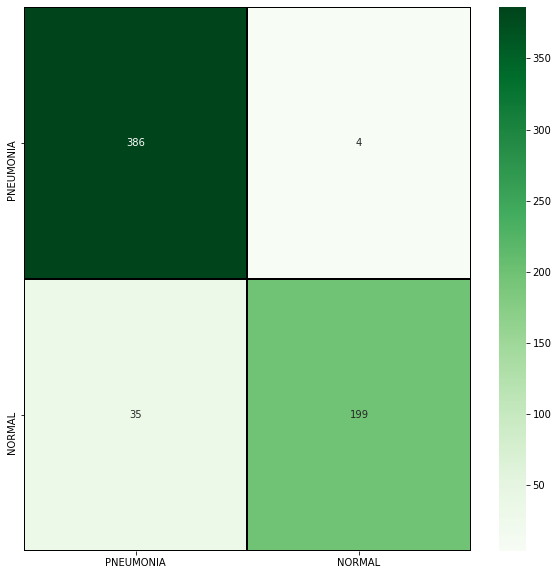

In [79]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Greens", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)